## Appendix：ラット自由行動下の軌跡のシミュレーション

([Raudies & Hasselmo, PLoS Comput Biol. 2012](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002553)) の擬似コードに従って作成．

In [1]:
using PyPlot, LinearAlgebra, Random, Distributions

In [2]:
ROOM_LEN = 2.2        # Width and height of environment (meters)
r = ROOM_LEN/2
PERIMETER_DIST = 0.03 # Perimeter region distance to walls (meters)
σv = 0.13            # Forward velocity Rayleigh distribution scale (m/sec)
μω = 0.0            # Rotation velocity Gaussian distribution mean (rad/sec)
σω = (330 / 360) * 2π # Rotation velocity Gaussian distribution standard deviation (rad/sec)
Δt = 0.02            # Simulation-step time increment (seconds)
ρdecel = 0.75;       # Velocity reduction factor when located in the perimeter

In [3]:
wrap(x) = mod(x, 2π); # limit 0~2π angle

Juliaの余りの関数は `rem(x, y)` と `mod(x, y)`がある。Juliaの`x % y`は`rem`と同じだが、Pythonの場合は`mod`と同じなので、注意。

In [14]:
println("% : ", -1 % 2, ", rem : ", rem(-1, 2), ", mod : ", mod(-1, 2))

% : -1, rem : -1, mod : 1


並進速度をレイリー分布，回転速度を正規分布に従うようにランダムにする．

壁の接ベクトルとラットの距離をdWall, 壁の法線ベクトルとラットの頭方向の角度の差をaWallとする．なお，壁とはラットの自己速度ベクトルと壁全体との交点である．

- ラットの自己速度ベクトルと壁全体との交点を求める．
- 交点の接ベクトルと法線ベクトルを求める．
- 接ベクトルとの距離をdWallとする．
- 法線ベクトルと成す角をaWallとする．

In [34]:
# for square room of size ROOM_LEN x ROOM_LEN
# d:dist, a:angle
function minDistAngleSquare(pos, θ)
    if 7π/4 ≤ θ < 2π || 0 ≤ θ < π/4
        dWall, aWall = ROOM_LEN - pos[1], θ
    elseif π/4 ≤ θ < 3π/4
        dWall, aWall = ROOM_LEN - pos[2], θ + 0.5π
    elseif 3π/4 ≤ θ < 5π/4
        dWall, aWall = pos[1], θ + π
    elseif 5π/4 ≤ θ < 7π/4
        dWall, aWall = pos[2], θ + 1.5π
    end
    aWall = wrap(aWall)
    return dWall, aWall
end;

In [4]:
# for square room of size ROOM_LEN x ROOM_LEN
# d:dist, a:angle
function minDistAngleCircle(pos, θ, r)
    pos = pos .- r
    vec = [cos(θ), sin(θ)]
    k = pos[1]*sin(θ) - pos[2]*cos(θ)
    ipos = [k*sin(θ), - k*cos(θ)] .+ sqrt(r^2 - k^2) * vec # pos of intersection
    dWall = abs(ipos[1]*(pos[1]-ipos[1])+ipos[2]*(pos[2]-ipos[2]))
    aWall = sign(ipos[2])*acos(ipos[1]/r) - θ
    return dWall, aWall
end;

In [35]:
function generateRatTrajectory(num_steps)
    # store arrays
    Position, Velocity = zeros(num_steps, 2), zeros(num_steps, 2)
    Speed, θ = zeros(num_steps), zeros(num_steps) # Forward speed, head direction

    # initial values
    θ[1], Speed[1] = rand() * 2π, 0
    Position[1, :] = [r, r] #clamp.(rand(2) * ROOM_LEN, -0.1, ROOM_LEN-0.1)
    Velocity[1, :] = Speed[1] * [sin(θ[1]), cos(θ[1])]
    
    # iteration of trajectory
    for i in 1:num_steps-1
        #dWall, aWall = minDistAngleCircle(Position[i, :], θ[i], r)
        #println("dWall:", dWall, ", aWall:", aWall)
        dWall, aWall = minDistAngleSquare(Position[i, :], θ[i])
        if (dWall < PERIMETER_DIST) && (abs(aWall) < π)
            Speed[i+1] = ρdecel * Speed[i] # deceleration
            θ[i+1] = wrap(sign(aWall) * (π - abs(aWall))+ (μω + randn()*σω)) #* Δt) # turn
        else
            Speed[i+1] = rand(Rayleigh(σv))
            θ[i+1] = wrap(θ[i] + (μω + randn()*σω) * Δt)
        end
        Position[i+1, :] = Position[i, :] + Velocity[i, :] * Δt
        Velocity[i+1, :] = Speed[i+1] * [sin(θ[i+1]), cos(θ[i+1])]
    end
    return Position, Velocity, Speed, θ
end;

In [36]:
num_timesteps = 10000
Position, Velocity, Speed, θ = generateRatTrajectory(num_timesteps);

黒点から始まり、赤点に終わる。

In [8]:
Θ = range(0, 2pi, length=100)

0.0:0.06346651825433926:6.283185307179586

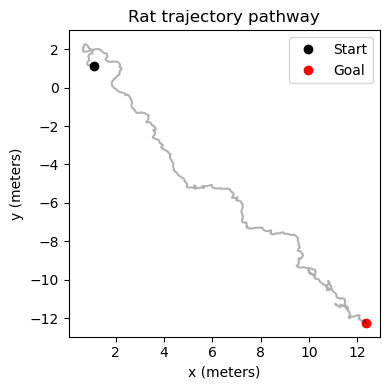

In [37]:
figure(figsize=(4, 4))
title("Rat trajectory pathway")
#plot(r.+cos.(Θ), r.+sin.(Θ))
xlabel("x (meters)"); ylabel("y (meters)")
#xlim((0, ROOM_LEN+0.01)); ylim((0, ROOM_LEN))
plot(Position[1, 1], Position[1, 2], "ko", label="Start")
plot(Position[end, 1], Position[end, 2], "ro", label="Goal")
plot(Position[:, 1], Position[:, 2], color="k", alpha=0.3)
legend()
tight_layout()

In [ ]:

X = -1:0.1:1

In [ ]:
figure(figsize=(5, 4.5))
axvline(x=0, color="gray", linestyle="dashed", linewidth=2)
axhline(y=0, color="gray", linestyle="dashed", linewidth=2)
plot(cos.(Θ), sin.(Θ))
plot(X, ipos[2]/ipos[1]*X)
plot(X, tan(θ) * (X.-pos[1]) .+pos[2])
plot(X, -ipos[1]/ipos[2] * (X.-ipos[1]) .+ipos[2])
quiver(pos[1], pos[2], cos(θ), sin(θ), color="red") 
quiver(pos[1], pos[2], sin(θ), -cos(θ))
quiver(ipos[1], ipos[2], ipos[1], ipos[2])
quiver(ipos[1], ipos[2], ipos[2], -ipos[1])
scatter(hpos[1], hpos[2])
scatter(ipos[1], ipos[2])
ylim(-1, 1);
xlim(-1, 1);
tight_layout()